In [6]:
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, add_messages, START, END
from langchain_groq import ChatGroq
from langgraph.checkpoint.memory import MemorySaver
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
import os

load_dotenv(override=True)

True

In [ ]:
# creating memory to store checkpoints
memory = MemorySaver()

# define tools
search_tool = TavilySearchResults(max_results=2)
tools = [search_tool]

# create llm instance and bind with tools
llm = ChatGroq(
    api_key=os.getenv('GROQ_API_KEY'),
    model = "llama-3.1-8b-instant"
)

llm_with_tools = llm.bind_tools(tools=tools)

# create graph state
class BasicState(TypedDict):
    messages : Annotated[list, add_messages]

# function to invoke llm
def chatbot(state : BasicState):
    return {
        "messages" : [llm_with_tools.invoke(state["messages"])]
    }

# router function
def tool_router(state : BasicState):
    llm_response = state["messages"][-1]
    if(hasattr(llm_response, "tool_calls")  and len(llm_response.tool_calls) > 0):
        return "tools"
    else:
        return "end"

#create Graph
graph = StateGraph(BasicState)

# add graph nodes
graph.add_node("chatbot", chatbot)
graph.add_node("tools", ToolNode(tools=tools))

# graph entry point
graph.set_entry_point("chatbot")

# graph edges
graph.add_conditional_edges("chatbot",tool_router, {"tools": "tools", "end":END})
graph.add_edge("tools","chatbot")

# compile with checkpoint and interrupt to review tool call by Human in Loop
app = graph.compile(checkpointer=memory, interrupt_before=["tools"])

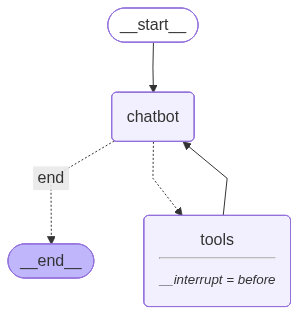

In [ ]:
from IPython.display import Image, display

# display graph
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
# creating config for user
config = {"configurable": {
    "thread_id":1
}}

# streaming app to review intermediate steps and very tool calls by Human In Loop
events = app.stream({
    "messages": [HumanMessage(content="What is current weather of Kolkata?")]
}, config=config, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is current weather of Kolkata?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (4tagd1874)
 Call ID: 4tagd1874
  Args:
    query: Kolkata weather update now


In [34]:
snapshot = app.get_state(config=config)
snapshot.next

('tools',)

In [ ]:
# running graph after Human in Loop validates tool call
events = app.stream(None, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================

The current weather in Kolkata is mostly cloudy with a high chance of rain and thunderstorms. The temperature is around 92-94°F (33-34°C) during the day and 81-83°F (27-28°C) at night. There is a moderate wind speed of 8-10 mph (13-16 km/h) and a humidity level of 61-69%. The UV index is moderate. It is recommended to bring a waterproof jacket and to drink plenty of water due to the hot weather.
